<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/05_simple_classification_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Simple Classification Problem

In a classification problem, we’re trying to predict which class a data
point belongs to.

Let’s say we have two classes of points: they are either red or blue. These are the
labels `(y)` of the points. 

Sure enough, we need to assign numeric values to them. We
could assign zero to red and one to blue. The class associated with zero is the
negative class, while one corresponds to the positive class.

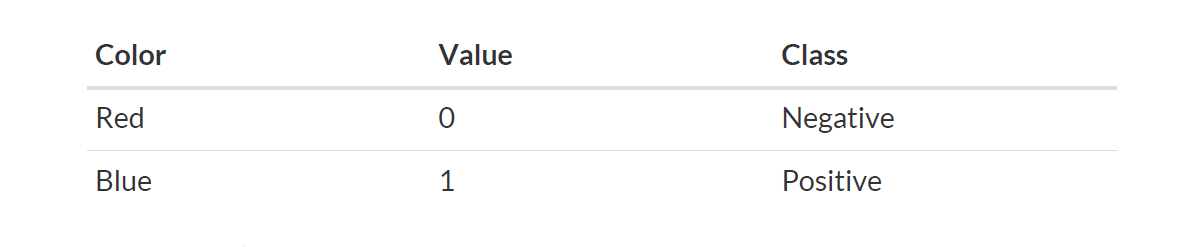

##Setup

In [ ]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter3()
# This is needed to render the plots in this chapter
from plots.chapter3 import *

In [ ]:
!wget https://github.com/rahiakela/deep-learning-research-and-practice/raw/main/deep-learning-with-pytorch-step-by-step/networks/linear_regression.py

In [ ]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

from linear_regression import LinearRegression

##Data Generation

Let’s start generating some synthetic data: we start with a vector of `100 (N)` points
for our feature `(x)` and create our labels `(y)` using `b = 1, w = 2`, and some Gaussian noise (epsilon).

In [ ]:
np.random.seed(42)

true_b = 1
true_w = 2
N = 100

# Data Generation
x = np.random.rand(N, 1)
epsilon = (.1 * np.random.rand(N, 1))
y = true_b + true_w * x + epsilon

Next, let's split our synthetic data into train and validation sets, shuffling the array
of indexes and using the first 80 shuffled points for training.

In [ ]:
# Shuffles the indices
idx = np.arange(N)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:int(N * .8)]
# Uses the remaining indices for validation
val_idx = idx[int(N * .8): ]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

##Naive Model Training

So, let's consider again with our previous important question:

Would the code inside the training loop change if we were using a
different optimizer, or loss, or even model?

The answer: NO.

The model training involves looping over the four gradient descent steps (or one
training step, for that matter) and those are always the same, regardless of which model, loss or optimizer we use.

Let’s take a look at the code once again:

###Data Preparation

After generating our
data points, the only preparation step performed so far was
transforming Numpy arrays into PyTorch tensors.

In [ ]:
%%writefile data_preparation/v0.py

device = "cuda" if torch.cuda.is_available() else "cpu"

# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors and then we send them to the chosen device
x_train_tensor = torch.as_tensor(x_train).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device)

In [ ]:
%run -i data_preparation/v0.py

Since we’re using the -i option, it works exactly as if we had copied the code from
the files into a cell and executed it.

###Model Configuration

For the purpose of organizing our code, we’ll include the following elements in the
model configuration part:

* a model
* a loss function
* an optimizer

In [ ]:
%%writefile model_configuration/v0.py

# This is redundant now, but it won't be when we introduce Datasets...
device = "cuda" if torch.cuda.is_available() else "cpu"

# Sets learning rate
lr = 0.1

torch.manual_seed(42)

# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines a SGD optimizer to update the parameters 
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction="mean")

In [ ]:
%run -i model_configuration/v0.py

###Model Training

This is the last part, where the actual training takes place. It loops over the gradient
descent steps.

* Step 1: compute model’s predictions
* Step 2: compute the loss
* Step 3: compute the gradients
* Step 4: update the parameters

Since we are not manually creating parameters anymore, the initialization is
handled inside each layer during model creation.

In [ ]:
%%writefile model_training/v0.py

# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
  # Sets model to TRAIN mode
  model.train()

  # Step 1 - Computes model's predicted output - forward pass
  yhat = model(x_train_tensor)

  # Step 2 - Computes the loss
  loss = loss_fn(yhat, y_train_tensor)

  # Step 3 - Computes gradients for both "b" and "w" parameters
  loss.backward()

  # Step 4 - Updates parameters using gradients and the learning rate
  optimizer.step()
  optimizer.zero_grad()

In [ ]:
%run -i model_training/v0.py

One last check to make sure we have everything right.

In [ ]:
print(model.state_dict())

How about writing a function that takes a model, a loss, and an optimizer and
returns another function that performs a training step?

The latter would then
take the features and corresponding labels as arguments and returning the
corresponding loss.

>Wait, what?! A function that returns another function?

Sounds complicated, right? 

It is not as bad as it sounds, though… that’s called a
higher-order function, and it is very useful for reducing boilerplate.

##Better Model Training

The higher-order function that builds a training step function for us is taking the key elements of our training loop: model, loss, and
optimizer. 

The actual training step function to be returned will have two
arguments, namely, features and labels, and will return the corresponding loss
value.

In [ ]:
def make_train_step(model, loss_fn, optimizer):

  # Builds function that performs a step in the train loop
  def perform_train_step(x, y):
    # Sets model to TRAIN mode
    model.train()

    # Step 1 - Computes model's predictions - forward pass
    yhat = model(x)

    # Step 2 - Computes the loss
    loss = loss_fn(yhat, y)

    # Step 3 - Computes gradients for "b" and "w" parameters
    loss.backward()

    # Step 4 - Updates parameters using gradients and the learning rate
    optimizer.step()
    optimizer.zero_grad()

    # Returns the loss
    return loss.item()

  # Returns the function that will be called inside the train loop
  return perform_train_step

Then we need to update our Model Configuration code to call this higher-order function to build a `train_step` function. 

But
we need to run a data preparation script first.

In [ ]:
%run -i data_preparation/v0.py

In [ ]:
%%writefile model_configuration/v1.py

# This is redundant now, but it won't be when we introduce Datasets...
device = "cuda" if torch.cuda.is_available() else "cpu"

# Sets learning rate
lr = 0.1

torch.manual_seed(42)

# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines a SGD optimizer to update the parameters 
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction="mean")

# Creates the train_step function for our model, loss function and optimizer
train_step = make_train_step(model, loss_fn, optimizer)

In [ ]:
%run -i model_configuration/v1.py

Let’s check our `train_step` function out!

In [ ]:
train_step

Looking good! 

Now we need to update our Model Training to replace the code
inside the loop with a call to our newly created function.

In [ ]:
%%writefile model_training/v1.py

# Defines number of epochs
n_epochs = 1000
# Keeping track of the training loss
losses = []

# For each epoch...
for epoch in range(n_epochs):
  # Performs one train step and returns the corresponding loss
  loss = train_step(x_train_tensor, y_train_tensor)
  losses.append(loss)

In [ ]:
%run -i model_training/v1.py

How do we check if our changes did not introduce any bugs? 

We can inspect our model’s `state_dict()`:

In [ ]:
# Checks model's parameters
print(model.state_dict())

##Dataset

In PyTorch, a dataset is represented by a regular Python class that inherits from the Dataset class. 

You can think of it as a list of tuples, each tuple corresponding to one point (features, label).

The most fundamental methods it needs to implement are:

* `__init__(self)`: it takes whatever arguments needed to build a list of tuples —it may be the name of a CSV file that will be loaded and processed; it may be two tensors, one for features, another one for labels; or anything else, depending on the task at hand.

* `__get_item__(self, index)`: it allows the dataset to be indexed so that it can work like a `list(dataset[i])` — it must return a `tuple (features, label)` corresponding to the requested data point.

* `__len__(self)`: it should simply return the size of the whole dataset so,
whenever it is sampled, its indexing is limited to the actual size.

Let’s build a simple custom dataset that takes two tensors as arguments: one for
the features, one for the labels. 

For any given index, our dataset class will return
the corresponding slice of each one of those tensors.



In [ ]:
class CustomDataset(Dataset):

  def __init__(self, x_tensor, y_tensor):
    self.x = x_tensor
    self.y = y_tensor

  def __getitem__(self, index):
    return (self.x[index], self.y[index])

  def __len__(self):
    return len(self.x)

In [ ]:
# Wait, is this a CPU tensor now? Why? Where is .to(device)?
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

train_data = CustomDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

We don’t want our whole training data to be loaded into GPU
tensors, as we have been doing in our example so far, because it
takes up space in our precious graphics card’s RAM.

But, we can use PyTorch’s TensorDataset class, which
will do pretty much the same as our custom dataset.

In [ ]:
train_data = TensorDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

OK, fine, but then again, why are we building a dataset anyway? 

We’re doing it because we want to use a....**DataLoader**.

###DataLoader

Until now, we have used the whole training data at every training step. It has been
batch gradient descent all along. This is fine for our ridiculously small dataset, sure,
but if we want to go serious about all this, we must use mini-batch gradient
descent. Thus, we need mini-batches. Thus, we need to slice our dataset
accordingly.

So we use PyTorch’s DataLoader class for this job. We tell it which dataset to use, the desired mini-batch size, and
if we’d like to shuffle it or not. That’s it!

>There is more to a DataLoader than meets the eye… it is also
possible to use it together with a sampler to fetch mini-batches
that compensate for imbalanced classes, for instance.

Our loader will behave like an iterator, so we can loop over it and fetch a different mini-batch every time.

In our example, we have only 80 training points, so I chose a mini-batch size of 16
to conveniently split the training set into five mini-batches.

In [ ]:
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

To retrieve a mini-batch, one can simply run the command below — it will return a
list containing two tensors, one for the features, another one for the labels:

In [ ]:
next(iter(train_loader))

How does this change our code so far? Let’s check it out!

First, we need to add both Dataset and DataLoader elements into our data
preparation part of the code. 

Also, notice that we do not send our tensors to the
device just yet.

In [ ]:
%%writefile data_preparation/v1.py

# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors
x_train_tensor = torch.as_tensor(x_train).float()
y_train_tensor = torch.as_tensor(y_train).float()

# Builds Dataset
train_data = TensorDataset(x_train_tensor, y_train_tensor)

# Builds DataLoader
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

In [ ]:
%run -i data_preparation//v1.py

Next, we need to incorporate the mini-batch gradient descent logic into our model
training part of the code.

In [ ]:
# we need to run the model configuration first
%run -i model_configuration/v1.py

In [ ]:
%%writefile model_training/v2.py

# Defines number of epochs
n_epochs = 1000
# Keeping track of the training loss
losses = []

# For each epoch...
for epoch in range(n_epochs):
  mini_batch_losses = []
  # mini-batch inner loop
  for x_batch, y_batch in train_loader:
    # the dataset "lives" in the CPU, so do our mini-batches 
    # therefore, we need to send those mini-batches to the device where the model "lives"
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    # Performs one train step and returns the corresponding loss for this mini-batch
    mini_batch_loss = train_step(x_batch, y_batch)
    # Keeping track of the loss inside each mini-batch
    mini_batch_losses.append(mini_batch_loss)
  
  # Computes average loss over all mini-batches 
  # That's the epoch loss
  loss = np.mean(mini_batch_losses)
  losses.append(loss)

In [ ]:
%run -i model_training/v2.py

Not so bad, right? So, it is time to check if our code still works well.

In [ ]:
print(model.state_dict())

Did you get slightly different values? 

Try running the whole
pipeline again:

In [ ]:
%run -i data_preparation//v1.py
%run -i model_configuration/v1.py
%run -i model_training/v2.py

In [ ]:
print(model.state_dict())

Since the DataLoader draws random samples, executing other
code between the last two steps of the pipeline may interfere
with the reproducibility of the results.

Did you notice it is taking longer to train now? Can you guess
why?

The training time is longer now because the inner loop is executed five
times for each epoch (in our example, since we are using a mini-batch of size 16 and we have 80 training data points in total, we execute the inner loop `80 / 16 = 5` times). 

So, in total, we are calling the train_step a total of 5,000 times now! No
wonder it’s taking longer!

###Mini-Batch

From now on, it is very unlikely that you’ll ever use (full) batch gradient descent again, both in this book or in real life :-) 

So, it makes sense to, once again, organize a
piece of code that’s going to be used repeatedly into its own function: the minibatch
inner loop!

The inner loop depends on three elements:

* the device where data is being sent to
* data loader to draw mini-batches from
* step function, returning the corresponding loss

In [ ]:
def mini_batch(device, data_loader, step):
  mini_batch_losses = []
  for x_batch, y_batch in data_loader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    mini_batch_loss = step(x_batch, y_batch)
    mini_batch_losses.append(mini_batch_loss)
  
  loss = np.mean(mini_batch_losses)
  return loss

Since we realized that we were executing five times more updates per epoch due to the mini-batch inner loop. Before, 1,000
epochs meant 1,000 updates. 

Now, we only need 200 epochs to perform the same
1,000 updates.

In [ ]:
%run -i data_preparation//v1.py
%run -i model_configuration/v1.py

In [ ]:
%%writefile model_training/v3.py

# Defines number of epochs
n_epochs = 200
losses = []

for epoch in range(n_epochs):
  # mini_batch inner loop
  loss = mini_batch(device, train_loader, train_step)
  losses.append(loss)

In [ ]:
%run -i model_training/v3.py

In [ ]:
# Checks model's parameters
print(model.state_dict())

###Random Split

PyTorch’s `random_split()` method is an easy and familiar way of performing a
training-validation split.

In [ ]:
%%writefile data_preparation/v2.py

torch.manual_seed(13)

# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.as_tensor(x).float()
y_tensor = torch.as_tensor(y).float()

# Builds dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# Performs the split
ratio = 0.8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train
# Performing train-validation split in PyTorch
train_data, val_data = random_split(dataset, [n_train, n_val])

# Builds a loader of each set
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=16)

In [ ]:
%run -i data_preparation/v2.py

##Model Evaluation

First, we need to use the model to compute predictions and then use the loss
function to compute the loss, given our predictions and the true labels.

And most importantly, we need to use the model’s `eval()` method. The only thing it
does is setting the model to evaluation mode (just like its `train()` counterpart
did), so the model can adjust its behavior accordingly when it has to perform some
operations, like `Dropout`.

Just like `make_train_step`, our new function, `make_val_step` is a higher-order
function as well.

In [ ]:
def make_val_step(model, loss_fn):

  # Builds function that performs a step in the validation loop
  def perform_val_step(x, y):
    # Sets model to EVAL mode
    model.eval()

    # Step 1 - Computes our model's predicted output forward pass
    yhat = model(x)

    # Step 2 - Computes the loss
    loss = loss_fn(yhat, y)

    # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
    return loss.item()

  return perform_val_step

And then, we update our Model Configuration code to include the creation of the
corresponding function for the validation step.

In [ ]:
%%writefile model_configuration/v2.py

device = "cuda" if torch.cuda.is_available() else "cpu"

# Sets learning rate
lr = 0.1

torch.manual_seed(42)

# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines a SGD optimizer to update the parameters 
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction="mean")

# Creates the train_step function for our model, loss function and optimizer
train_step = make_train_step(model, loss_fn, optimizer)

# Creates the val_step function for our model and loss function
val_step = make_val_step(model, loss_fn)

In [ ]:
%run -i model_configuration/v2.py

Finally, we need to change the training loop to include the evaluation of our model.

In [ ]:
%%writefile model_training/v4.py

# Defines number of epochs
n_epochs = 200
losses = []
val_losses = []

for epoch in range(n_epochs):
  # mini_batch inner loop
  loss = mini_batch(device, train_loader, train_step)
  losses.append(loss)

  # VALIDATION - no gradients in validation to prevent gradient computation!
  with torch.no_grad():
    val_loss = mini_batch(device, val_loader, val_step)
    val_losses.append(val_loss)

In [ ]:
%run -i model_training/v4.py

In [ ]:
# Checks model's parameters
print(model.state_dict())

Let’s take a look at both losses - training, and validation:

In [ ]:
%run -i data_preparation/v2.py
%run -i model_configuration/v2.py
%run -i model_training/v4.py

In [ ]:
fig = plot_losses(losses, val_losses)

##TensorBoard

In [ ]:
!mkdir runs

In [ ]:
%tensorboard --logdir runs

It all starts with the creation of a SummaryWriter.

In [ ]:
writer = SummaryWriter("runs/test")

The summary writer implements several methods to allow us sending information
to TensorBoard.

In [ ]:
# let's add model to graph
try:
  writer.add_graph(model)
except TypeError as error:
  print(error)

So, we do need to send it some inputs together with our model… 

Let’s fetch a
mini-batch of data points from our train_loader and then pass it as input to
add_graph:

In [ ]:
# Fetching a tuple of feature (sample_x) and label (sample_y)
sample_x, sample_y = next(iter(train_loader))

# Since our model was sent to device, we need to do the same with the data
# Even here, both model and data need to be on the same device!
writer.add_graph(model, sample_x.to(device))

In [ ]:
%tensorboard --logdir runs

We can use `add_scalars` method to send multiple scalar values at once, and it needs three arguments:

* `main_tag`: the parent name of the tags or, the "group tag"
* `tag_scalar_dict`: the dictionary containing the key: value pairs for the scalars you want to keep track of
* `global_step`: step value, that is, the index you’re associating with the values you’re sending in the dictionary - the epoch comes to mind in our case, as losses are computed for each epoch

In [ ]:
writer.add_scalars("loss", {"training": loss, "validation": val_loss}, epoch)

In [ ]:
%tensorboard --logdir runs

We need to incorporate these elements into our Model
Configuration and Model Training codes.

In [ ]:
%run -i data_preparation/v2.py

In [ ]:
%%writefile model_configuration/v3.py

device = "cuda" if torch.cuda.is_available() else "cpu"

# Sets learning rate
lr = 0.1

torch.manual_seed(42)

# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines a SGD optimizer to update the parameters 
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction="mean")

# Creates the train_step function for our model, loss function and optimizer
train_step = make_train_step(model, loss_fn, optimizer)

# Creates the val_step function for our model and loss function
val_step = make_val_step(model, loss_fn)

# Creates a Summary Writer to interface with TensorBoard
writer = SummaryWriter("runs/simple_linear_regression")

# Fetches a single mini-batch so we can use add_graph
x_dummy, y_dummy = next(iter(train_loader))
writer.add_graph(model, x_dummy.to(device))

In [ ]:
%run -i model_configuration/v3.py

In [ ]:
%%writefile model_training/v5.py

# Defines number of epochs
n_epochs = 200
losses = []
val_losses = []

for epoch in range(n_epochs):
  # mini_batch inner loop
  loss = mini_batch(device, train_loader, train_step)
  losses.append(loss)

  # VALIDATION - no gradients in validation to prevent gradient computation!
  with torch.no_grad():
    val_loss = mini_batch(device, val_loader, val_step)
    val_losses.append(val_loss)

  # Records both losses for each epoch under tag "loss"
  writer.add_scalars(main_tag="loss",
                     tag_scalar_dict={"training": loss, "validation": val_loss}, 
                     global_step=epoch)

# Closes the writer
writer.close()

In [ ]:
%run -i model_training/v5.py

In [ ]:
# Checks model's parameters
print(model.state_dict())

Now, let’s inspect TensorBoard.

In [ ]:
%tensorboard --logdir runs

This is the same plot we’ve built before using our lists and Matplotlib. 

If our model
were big or complex enough to take at least a couple of minutes to train, we would
be able to see the evolution of our losses in TensorBoard during training.

##Saving and Loading Models

To checkpoint a model, we basically have to save its state to a file so that it can be loaded back later - nothing special, actually.

Now, wrap everything into a Python dictionary and use `torch.save()` to dump it all into a file.

In [ ]:
checkpoint = {
  "epoch": n_epochs,
  "model_state_dict": model.state_dict(),
  "optimizer_state_dict": optimizer.state_dict(),
  "loss": losses,
  "val_loss": val_losses
}

torch.save(checkpoint, "model_checkpoint.pth")

###Resuming Training

If we’re starting fresh, we have to set up the stage before actually loading the model. This means
we need to load the data and configure the model.

In [ ]:
%run -i data_preparation/v2.py
%run -i model_configuration/v3.py

In [ ]:
print(model.state_dict())

Now we are ready to load the model back.

In [ ]:
# load the dictionary back
checkpoint = torch.load("model_checkpoint.pth")

# load model and optimizer state dictionaries back
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

# load everything else into their corresponding variables
saved_epoch = checkpoint["epoch"]
saved_losses = checkpoint["loss"]
saved_val_losses = checkpoint["val_loss"]

# always use TRAIN for resuming training
model.train()

In [ ]:
print(model.state_dict())

Cool, we recovered our model’s state, and we can resume training.

Next, we can run Model Training V5 to train it for another 200 epochs.

In [ ]:
%run -i model_training/v5.py

In [ ]:
print(model.state_dict())

Let’s check the evolution of the losses, before and after checkpointing.

In [ ]:
fig = plot_resumed_losses(saved_epoch, saved_losses, saved_val_losses, n_epochs,losses, val_losses)

Clearly, the loss was already at a minimum before the checkpoint so, nothing has changed!

###Deploying / Making Predictions

Again, if we’re starting fresh, we have to set up the stage before actually loading the model. But, this
time, we only need to configure the model:

In [ ]:
%run -i model_configuration/v3.py

Since the model is fully trained, we don’t need to load the optimizer or anything else.

In [ ]:
checkpoint = torch.load("model_checkpoint.pth")

model.load_state_dict(checkpoint["model_state_dict"])
print(model.state_dict())

After recovering our model’s state, we can finally use it to make predictions for
new inputs:

In [ ]:
new_inputs = torch.tensor([[.20], [.34], [.57]])

# always use EVAL for fully trained models!
model.eval()
model(new_inputs.to(device))

After loading a fully trained model for deployment / to make
predictions, make sure you ALWAYS set it to evaluation mode.

##Putting It All Together

In [ ]:
# %load data_preparation/v2.py

torch.manual_seed(13)

# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.as_tensor(x).float()
y_tensor = torch.as_tensor(y).float()

# Builds dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# Performs the split
ratio = 0.8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train
# Performing train-validation split in PyTorch
train_data, val_data = random_split(dataset, [n_train, n_val])

# Builds a loader of each set
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=16)

In [ ]:
# %load model_configuration/v3.py

device = "cuda" if torch.cuda.is_available() else "cpu"

# Sets learning rate
lr = 0.1

torch.manual_seed(42)

# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines a SGD optimizer to update the parameters 
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction="mean")

# Creates the train_step function for our model, loss function and optimizer
train_step = make_train_step(model, loss_fn, optimizer)

# Creates the val_step function for our model and loss function
val_step = make_val_step(model, loss_fn)

# Creates a Summary Writer to interface with TensorBoard
writer = SummaryWriter("runs/simple_linear_regression")

# Fetches a single mini-batch so we can use add_graph
x_sample, y_sample = next(iter(train_loader))
writer.add_graph(model, x_sample.to(device))

In [ ]:
# %load model_training/v5.py

# Defines number of epochs
n_epochs = 200
losses = []
val_losses = []

for epoch in range(n_epochs):
  # mini_batch inner loop
  loss = mini_batch(device, train_loader, train_step)
  losses.append(loss)

  # VALIDATION - no gradients in validation to prevent gradient computation!
  with torch.no_grad():
    val_loss = mini_batch(device, val_loader, val_step)
    val_losses.append(val_loss)

  # Records both losses for each epoch under tag "loss"
  writer.add_scalars(main_tag="loss",
                     tag_scalar_dict={"training": loss, "validation": val_loss}, 
                     global_step=epoch)

# Closes the writer
writer.close()

In [ ]:
print(model.state_dict())

In [ ]:
%tensorboard --logdir runs

This is the general structure you’ll use over and over again for
training PyTorch models.

Sure, a different dataset and problem will require a different
model and loss function, and you may want to try a different
optimizer and a cycling learning rate, but
the rest is likely to remain exactly the same.